In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error, mean_absolute_error
#rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

bookcolors = {'crimson': '#a50026', 'red': '#d73027', 'redorange': '#f46d43',
              'orange': '#fdae61', 'yellow': '#fee090', 'sky': '#e0f3f8', 
              'babyblue': '#abd9e9', 'lightblue': '#74add1', 'blue': '#4575b4',
              'purple': '#313695'}

In [66]:
def data():
    df = pd.DataFrame(data={"sqfeet":[700,950,800,900,750]})
    df["rent"] = pd.Series([1125,1350,1135,1300,1150])
    df = df.sort_values('sqfeet')
    return df

df = data()
df

,sqfeet,rent
0,700,1125
4,750,1150
2,800,1135
3,900,1300
1,950,1350


In [65]:
def stub_predict(x_train, y_train, split):
    left = y_train[x_train<split]
    right = y_train[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)    
    return [lmean if x<split else rmean for x in x_train]

eta = 0.75
splits = [None,850, 850, 925, 725]
stages = 4

def boost(df, xcol, ycol, splits, eta, stages):
    f0 = df[ycol].mean()
    df['F0'] = f0

    df['dir1'] = df[ycol] - df.F0
    df['delta1'] = stub_predict(df[xcol], df.dir1, splits[1])
    df['F1'] = df.F0 + eta * df.delta1

    df['dir2'] = df[ycol] - df.F1
    df['delta2'] = stub_predict(df[xcol], df.dir2, splits[2])
    df['F2'] = df.F1 + eta * df.delta2

    df['dir3'] = df[ycol] - df.F2
    df['delta3'] = stub_predict(df[xcol], df.dir3, splits[3])
    df['F3'] = df.F2 + eta * df.delta3

    mse = [mean_squared_error(df[ycol], df['F'+str(s)]) for s in range(stages)]
    mae = [mean_absolute_error(df[ycol], df['F'+str(s)]) for s in range(stages)]
    return mse, mae

mse,mae = boost(df, 'sqfeet', 'rent', splits, eta, stages)
df

,sqfeet,rent,F0,dir1,delta1,F1,dir2,delta2,F2,dir3,delta3,F3
0,700,1125,1212.0,-87.0,-75.333333,1155.50,-30.50,-18.833333,1141.3750,-16.3750,-8.015625,1135.363281
4,750,1150,1212.0,-62.0,-75.333333,1155.50,-5.50,-18.833333,1141.3750,8.6250,-8.015625,1135.363281
2,800,1135,1212.0,-77.0,-75.333333,1155.50,-20.50,-18.833333,1141.3750,-6.3750,-8.015625,1135.363281
3,900,1300,1212.0,88.0,113.000000,1296.75,3.25,28.250000,1317.9375,-17.9375,-8.015625,1311.925781
1,950,1350,1212.0,138.0,113.000000,1296.75,53.25,28.250000,1317.9375,32.0625,32.062500,1341.984375


In [36]:
# manually print table in python
# for small phone, make 2 tables
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,0:4]]), r"\\")

print
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,4:]]), r"\\")

700 & 1125 & 1212 & -87 \\
750 & 1150 & 1212 & -62 \\
800 & 1135 & 1212 & -77 \\
900 & 1300 & 1212 & 88 \\
950 & 1350 & 1212 & 138 \\
-75 & 1155 & -30 & -18 & 1141 & -16 & -8 & 1135 \\
-75 & 1155 & -5 & -18 & 1141 & 8 & -8 & 1135 \\
-75 & 1155 & -20 & -18 & 1141 & -6 & -8 & 1135 \\
113 & 1296 & 3 & 28 & 1317 & -17 & -8 & 1311 \\
113 & 1296 & 53 & 28 & 1317 & 32 & 32 & 1341 \\


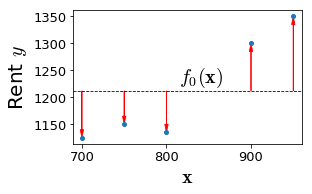

In [53]:
f0 = df.rent.mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2.5), sharex=True)
plt.tight_layout()
ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.text(815, f0+15, r"$f_0({\bf x})$", fontsize=20)

ax.set_ylabel(r"Rent $y$", fontsize=20)
ax.set_xlabel(r"${\bf x}$", fontsize=20)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    if y-yhat!=0:
        ax.arrow(x, yhat, 0, y-yhat,
                  length_includes_head=True,
                  fc='r', ec='r',
                  linewidth=0.8,
                  head_width=4, head_length=15,  
                 )

plt.show()

In [80]:
stages = 4
df = data() # fresh data

df_mse = pd.DataFrame(data={"stage":range(stages)})

for eta in np.arange(.5, 1, .1):
    mse,mae = boost(df, 'sqfeet', 'rent', splits, eta, stages)
    df_mse[f'mse_{eta:.2f}'] = mse

mse = [mean_squared_error(df.rent, df[f'F{s}']) for s in range(4)]
df_mse

,stage,mse_0.50,mse_0.60,mse_0.70,mse_0.80,mse_0.90
0,0,8826.000000,8826.000000,8826.000000,8826.000000,8826.000000
1,1,2441.500000,1675.360000,1079.473333,653.840000,398.460000
2,2,845.375000,531.257600,382.285933,326.953600,314.184600
3,3,313.707031,141.521456,100.884609,117.810304,145.197317


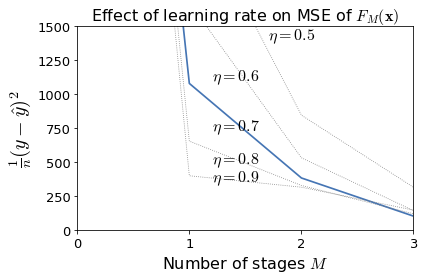

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)

maxy = 1500

mins = []
for eta in np.arange(.5, 1, .1):
    mins.append( np.min(df_mse[f'mse_{eta:.2f}']) )

min_eta_index = np.argmin(mins)

i = 0
for eta in np.arange(.5, 1, .1):
    color = 'grey'
    lw = .8
    ls = ':'
    if i==min_eta_index:
        color = bookcolors['blue']
        lw = 1.7
        ls = '-'
    ax.plot(df_mse.stage,df_mse[f'mse_{eta:.2f}'],
            linewidth=lw,
            linestyle=ls,
            c=color)
    xloc = 1.2
    yloc = (df_mse[f'mse_{eta:.2f}'].values[1] + df_mse[f'mse_{eta:.2f}'].values[2])/2
    if yloc>maxy:
        yloc = maxy-100
        xloc +=  .5
    ax.text(xloc, yloc, f"$\\eta={eta:.1f}$",
            fontsize=16)
    i += 1

plt.axis([0,stages-1,0,maxy])

ax.set_ylabel(r"$\frac{1}{n}(y-\hat y)^2$", fontsize=20)
ax.set_xlabel(r"Number of stages $M$", fontsize=16)
ax.set_title(r'Effect of learning rate on MSE of $F_M({\bf x})$', fontsize=16)
ax.set_xticks(range(0,stages))

plt.tight_layout()
plt.show()

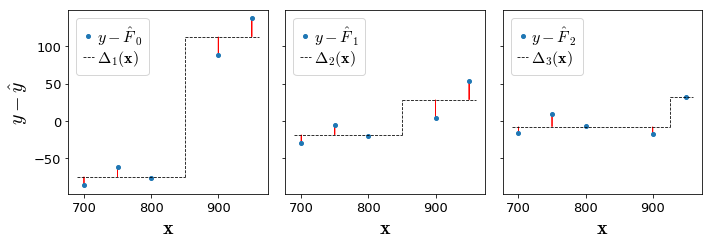

In [55]:
def draw_stub(ax, x_train, y_train, y_pred, split, stage):
    line1, = ax.plot(x_train, y_train, 'o',
                     linewidth=.8, markersize=4,
                     label=f"$y-\\hat F_{stage-1}$")
    label = r"$\Delta_"+str(stage)+r"({\bf x})$"
    left = y_pred[x_train<split]
    right = y_pred[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)
    line2, = ax.plot([x_train.min()-10,split], [lmean,lmean],
             linewidth=.8, linestyle='--', c='k', label=label)
    ax.plot([split,x_train.max()+10], [rmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.plot([split,split], [lmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.legend(handles=[line1,line2], fontsize=16,
              loc='upper left', 
              labelspacing=.1,
              handletextpad=.2,
              handlelength=.7,
              frameon=True)

def draw_residual(ax, x_train, y_train, y_hat):
    for x,y,yhat in zip(x_train, y_train, y_hat):
        if y-yhat!=0:
            ax.arrow(x, yhat, 0, y-yhat,
                      length_includes_head=True,
                      fc='r', ec='r',
                      linewidth=0.8,
                     )

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)

axes[0].set_ylabel(r"$y-\hat y$", fontsize=20)
for a in range(3):
    axes[a].set_xlabel(r"${\bf x}$", fontsize=20)
    
draw_stub(axes[0], df.sqfeet, df.dir1, df.delta1, splits[1], stage=1)
draw_residual(axes[0], df.sqfeet,df.dir1,df.delta1)

draw_stub(axes[1], df.sqfeet, df.dir2, df.delta2, splits[2], stage=2)
draw_residual(axes[1], df.sqfeet,df.dir2,df.delta2)

draw_stub(axes[2], df.sqfeet, df.dir3, df.delta3, splits[3], stage=3)
draw_residual(axes[2], df.sqfeet,df.dir3,df.delta3)

plt.tight_layout()

if False:
    axes[2][0].plot(df.sqfeet,df.dir4,'o', linewidth=.8, markersize=4)
    split = splits[4]
    left = df.delta4[df.sqfeet<split]
    right = df.delta4[df.sqfeet>split]
    lmean = np.mean(left)
    rmean = np.mean(right)
    axes[2][0].plot([df.sqfeet.min()-10,split], [lmean,lmean],
             linewidth=.8, linestyle='--', c='k')
    axes[2][0].plot([split,df.sqfeet.max()+10], [rmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    axes[2][0].plot([split,split], [lmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    axes[2][0].text(820, rmean+3.5, r"$\Delta_4({\bf x})$", fontsize=20)
    # draw arrows
    for x,y,yhat in zip(df.sqfeet,df.dir4,df.delta4):
        if y-yhat!=0:
            axes[2][0].arrow(x, yhat, 0, y-yhat,
                      length_includes_head=True,
                      fc='r', ec='r',
                      linewidth=0.8,
    #                  head_width=2, head_length=8,
                     )

    axes[2][1].plot(df.sqfeet,df.dir5,'o', linewidth=.8, markersize=4)

        
plt.savefig('/tmp/t.svg')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'scaled1'

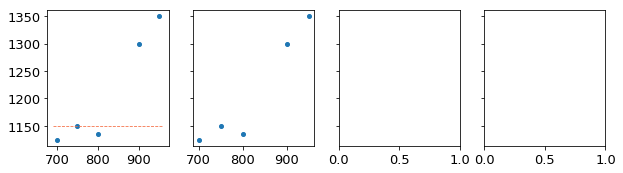

In [7]:
f0 = df.rent.median()

red = bookcolors['redorange']
blue = bookcolors['blue']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2.5), sharey=True)
#plt.tight_layout()

#axes[0][0].plot(df.sqfeet,df.rent,'-o', linewidth=.8, markersize=4)

axes[0].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[0].plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c=red)

# plt.xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
# plt.text(df.sqfeet.min()+5, f0+15, r"$f_0({\bf x})$",
#          fontsize=20)
axes[0].set
dir = np.sign(df.rent - f0) * 50
stage = 1
y_hat = np.array

axes[1].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[1].plot(df.sqfeet, f0+df.scaled1,
         linewidth=.8, linestyle='--', c=red)

axes[2].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[2].plot(df.sqfeet, f0+df.scaled1+df.scaled2,
         linewidth=.8, linestyle='--', c=red)

axes[3].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[3].plot(df.sqfeet, f0+df.scaled1+df.scaled2+df.scaled3,
         linewidth=.8, linestyle='--', c=blue)
#axes[0].text(700, 1325, r"$f_0({\bf x})$")
axes[0].set_title(r"$F_0({\bf x}) = f_0({\bf x})$", fontsize=18)
axes[1].set_title(r"$F_1({\bf x})$", fontsize=18)
axes[2].set_title(r"$F_2({\bf x})$", fontsize=18)
axes[3].set_title(r"$F_3({\bf x})$", fontsize=18)
plt.savefig('/tmp/t.svg')
plt.show()